## BC COVID-19 Visualizations

### Import libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors

### Import data

In [2]:
confirmed_df = pd.read_csv('data/confirmed.csv')
deaths_df = pd.read_csv('data/deaths.csv')
recovered_df = pd.read_csv('data/recovered.csv')
df_list = [confirmed_df, deaths_df, recovered_df]
suffix_list = ['confirmed', 'deaths', 'recovered']

### Set regions

In [3]:
region_list = ['VancouverCoastal', 'Fraser', 'Island', 'Interior', 'Northern']
region_list_daily = ['VancouverCoastal_daily', 'Fraser_daily', 'Island_daily', 'Interior_daily', 'Northern_daily']

### Calculate daily cases

In [4]:
def calculate_daily_cases(df, region, suffix):
    daily_region_cases = '{}_daily_{}'.format(region, suffix)
    region_lookup = '{}_{}'.format(region, suffix)
    df.loc[0, daily_region_cases] = df.loc[0, region_lookup]
    for i in range(1, len(df)):
        daily_region_case = df.loc[i, region_lookup] - df.loc[i-1, region_lookup]
        df.loc[i, daily_region_cases] = daily_region_case

for df, suffix in zip(df_list, suffix_list):
    for region in region_list:
        calculate_daily_cases(df, region, suffix)

### Calculate total cases

In [5]:
for df, suffix in zip(df_list, suffix_list):
    mod_region_list = list(map(lambda region: '{}_{}'.format(region, suffix), region_list))
    mod_region_list_daily = list(map(lambda region: '{}_{}'.format(region, suffix), region_list_daily))
    df['total_{}'.format(suffix)] = df[mod_region_list].sum(axis=1)
    df['total_daily_{}'.format(suffix)] = df[mod_region_list_daily].sum(axis=1)

### Create merged dataframe

In [6]:
merged_df = confirmed_df.merge(deaths_df, how='left', on=['DayCount', 'Date']).merge(recovered_df, how='left', on=['DayCount', 'Date'])

### Calculate active cases

In [7]:
def calculate_active_cases(row, region):
    return row['{}_confirmed'.format(region)] - row['{}_deaths'.format(region)] - row['{}_recovered'.format(region)]

merged_df['total_active'] = merged_df.apply(lambda row: calculate_active_cases(row, 'total'), axis=1)
for region in region_list:
    merged_df['{}_active'.format(region)] = merged_df.apply(lambda row: calculate_active_cases(row, region), axis=1)

### Define plotting methods

In [8]:
def plot_total_cases(useLog=False, active=False):
    suffix = 'active' if active else 'confirmed'
    case_plot = merged_df['total_{}'.format(suffix)]
    title = '# of {} Cases in BC'.format(suffix.capitalize())   
    yLabel = '# of Cases'
    if useLog:
        case_plot = np.log1p(case_plot)
        title = 'Log of {}'.format(title)
        yLabel = 'Log of {}'.format(yLabel)
    plt.figure(figsize=(9, 5))
    plt.plot(confirmed_df['DayCount'], case_plot)
    plt.title(title, size=12)
    plt.xlabel('Days Since 1/27/2020 (First Case)', size=12)
    plt.ylabel(yLabel, size=12)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.show()

def plot_cases_by_type():
    f, ax = plt.subplots(figsize=(9,5))
    day_count = merged_df['DayCount'].values
    plt.bar(day_count, merged_df['total_recovered'].values, bottom=merged_df['total_active'], color='green')
    plt.bar(day_count, merged_df['total_active'].values, bottom=merged_df['total_deaths'], color='orange')
    plt.bar(day_count, merged_df['total_deaths'].values, color='red')
    plt.legend(['Recovered', 'Active', 'Deaths'], prop={'size': 12})
    plt.xlabel('Days Since 1/27/2020 (First Case)', size=12)
    plt.ylabel('# of Total Cases Confirmed', size=12)
    plt.show()
    
def plot_daily_increases():
    plt.figure(figsize=(9, 5))
    plt.bar(confirmed_df['DayCount'], merged_df['total_daily_confirmed'])
    plt.title('Daily Increases in Confirmed Cases', size=12)
    plt.xlabel('Days Since 1/27/2020 (First Case)', size=12)
    plt.ylabel('# of Cases', size=12)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.show()
    
def plot_cases_by_region_line(useLog=False, active=False):
    plt.figure(figsize=(9, 5))
    suffix = 'active' if active else 'confirmed'
    title = '# of {} Cases in BC by Region'.format(suffix.capitalize())
    for region in region_list:
        case_plot = merged_df['{}_{}'.format(region, suffix)]
        if useLog:
            case_plot = np.log1p(case_plot)
        plt.plot(merged_df['DayCount'], case_plot)
    yLabel = '# of Cases'
    if useLog:
        title = 'Log of {}'.format(title)
        yLabel = 'Log of {}'.format(yLabel)
    plt.title(title, size=12)
    plt.xlabel('Days Since 1/27/2020 (First Case)', size=12)
    plt.ylabel(yLabel, size=12)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.legend(region_list, prop={'size': 12})
    plt.show()
    
def plot_cases_by_region_bar(daily=False, active=False):
    most_recent_cases = merged_df.iloc[[-1]]
    suffix = 'active' if active else 'confirmed'
    regions = list(map(lambda region: '{}_{}'.format(region, suffix), region_list))
    title = 'Total {} Cases by Region'.format(suffix.capitalize())
    if daily:
        regions = list(map(lambda region: '{}_confirmed'.format(region), region_list_daily))
        title = 'Total {} Cases by Region {}'.format(suffix.capitalize(), most_recent_cases['Date'].values[0])
    total_recent_cases = most_recent_cases[regions].values[0].astype(int)
    fig, ax = plt.subplots()    
    width = 0.75
    ind = np.arange(len(total_recent_cases))
    ax.barh(ind, total_recent_cases, width)
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(regions, minor=False)
    for i, v in enumerate(total_recent_cases):
        ax.text(v + 3, i + .25, str(v))
    plt.title(title)
    plt.xlabel('Number of Cases')
    plt.ylabel('Health Region')
    plt.show()
    
def plot_daily_increases_vs_total_confirmed(useLog=False):
    plt.figure(figsize=(9, 5))
    total_plot = merged_df['total_confirmed']
    daily_plot = merged_df['total_daily_confirmed']
    if useLog:
        total_plot = np.log1p(total_plot)
        daily_plot = np.log1p(daily_plot)
    plt.plot(total_plot, daily_plot)
    title = 'Daily Increases vs Total Confirmed Cases'
    xLabel = '# of Total Cases Confirmed'
    yLabel = '# of New Daily Cases Confirmed'
    if useLog:
        xLabel = 'Log of # of Total Cases Confirmed'
        yLabel = 'Log of # of New Daily Cases Confirmed'
        title = 'Log of Daily Increases vs Total Confirmed Cases'
    plt.title(title, size=12)
    plt.xlabel('# of Total Cases Confirmed', size=12)
    plt.ylabel('# of New Daily Cases Confirmed', size=12)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.show()

### Plot active cases

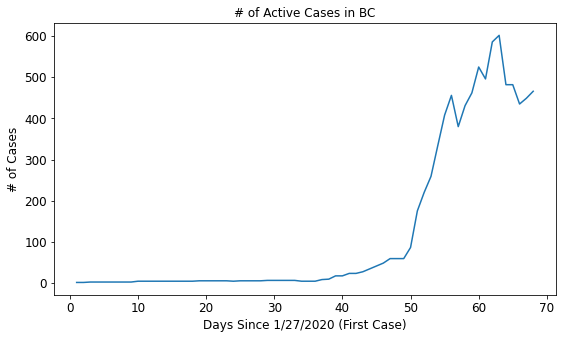

In [9]:
plot_total_cases(active=True)

### Plot log of active cases

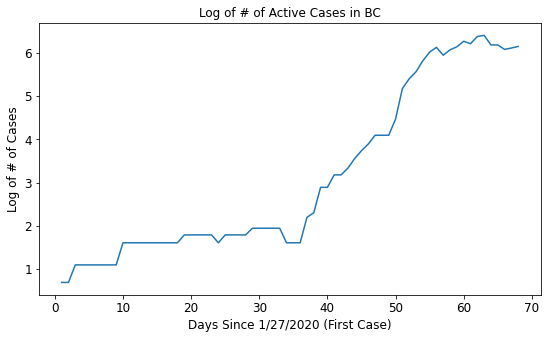

In [10]:
plot_total_cases(useLog=True, active=True)

### Plot total confirmed cases

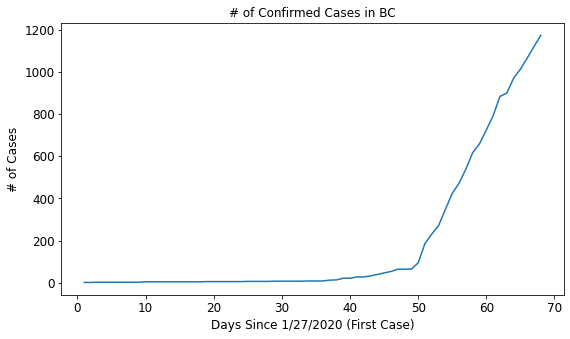

In [11]:
plot_total_cases()

### Plot log of total confirmed cases

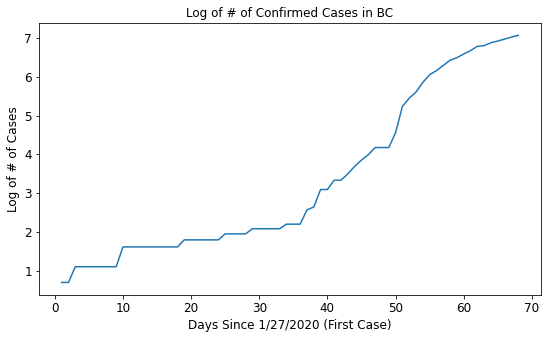

In [12]:
plot_total_cases(useLog=True)

### Plot confirmed cases by type

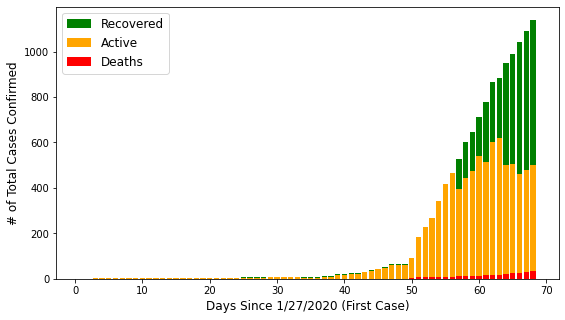

In [13]:
plot_cases_by_type()

### Plot daily increases

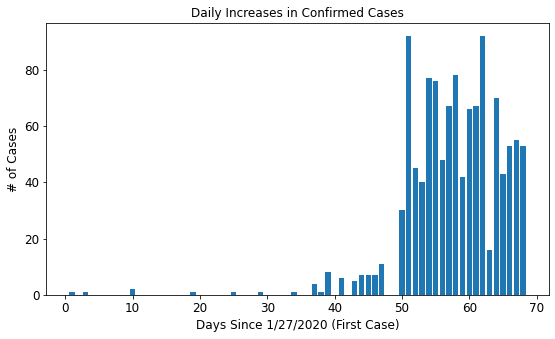

In [14]:
plot_daily_increases()

### Plot active cases by region

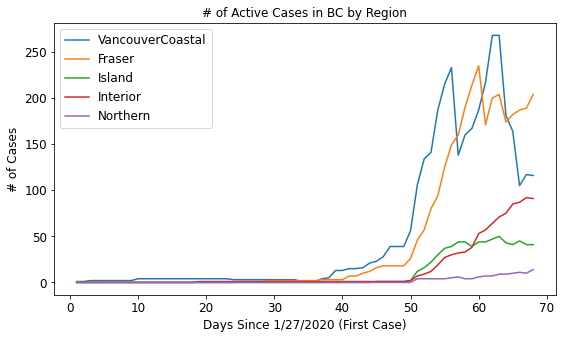

In [15]:
plot_cases_by_region_line(active=True)

### Plot log of active cases by region

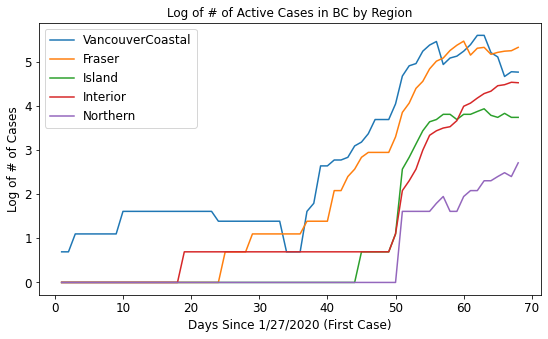

In [16]:
plot_cases_by_region_line(useLog=True, active=True)

### Plot confirmed cases by region

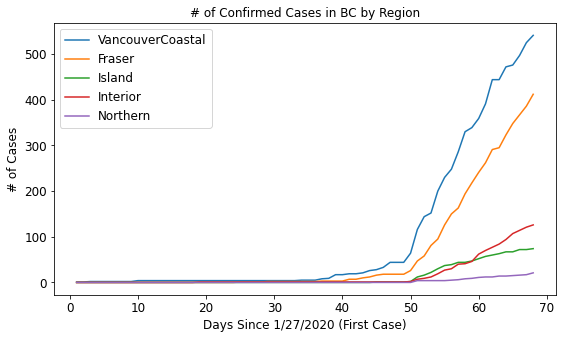

In [17]:
plot_cases_by_region_line()

### Plot log of total confirmed cases by region

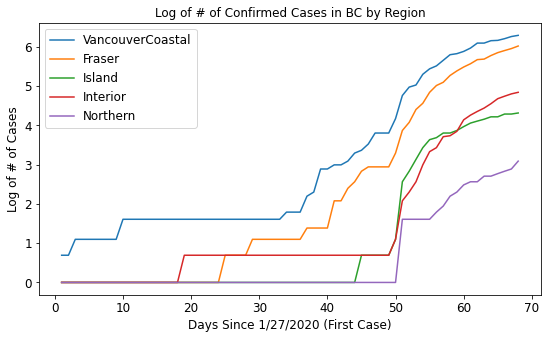

In [18]:
plot_cases_by_region_line(useLog=True)

### Plot cumulative active cases by region

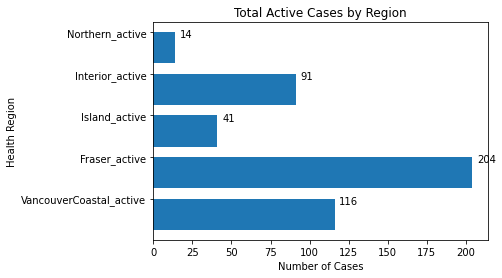

In [19]:
plot_cases_by_region_bar(active=True)

### Plot cumulative confirmed cases by region

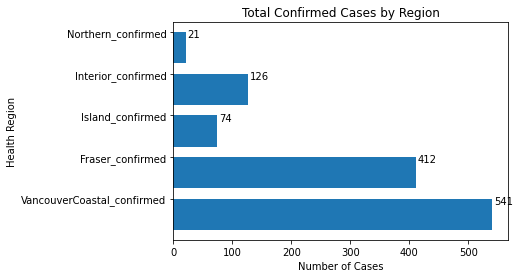

In [20]:
plot_cases_by_region_bar()

### Plot most recent day confirmed cases by region

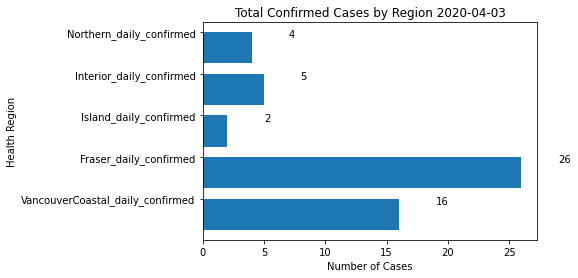

In [21]:
plot_cases_by_region_bar(daily=True)

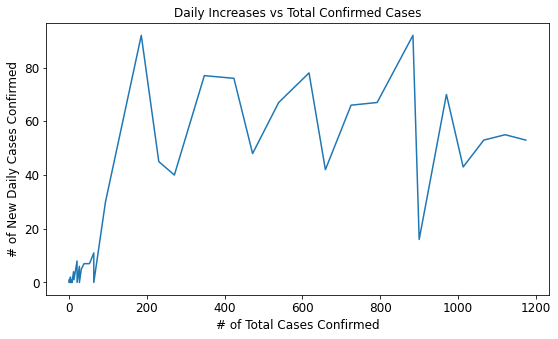

In [22]:
plot_daily_increases_vs_total_confirmed()

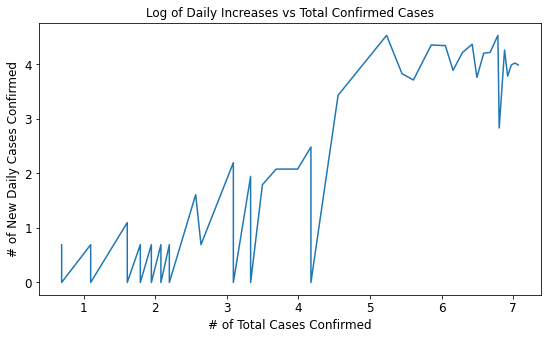

In [23]:
plot_daily_increases_vs_total_confirmed(useLog=True)